In [5]:
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import readability


In [2]:
list_=[]
df = pd.read_csv('forumdata/doctorslounge_data.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_0.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_1.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_2.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_3.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_4.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/ehealthforum_data_5.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/webmd_data_0.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/webmd_data_1.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/webmd_data_2.csv', index_col=None, header=0)
list_.append(df)
df = pd.read_csv('forumdata/scarleteen_data.csv', index_col=None, header=0)
list_.append(df)

In [3]:
df=pd.concat(list_,ignore_index=True)
df=df.drop([df.columns[0],'response_time'],1)
df=df.drop_duplicates()

In [7]:
posts=df.shape[0]
convos=df['post'].unique().shape[0]
print "Forum dataset consists of %s posts across %s conversations" % (posts,convos)

Forum dataset consists of 145255 posts across 63846 conversations


In [22]:
#just lists to turn into a new dataframe (this is quicker than append)
post_l=[]
subj_l=[]
ask_l=[]
doc_l=[]
oth_l=[]
askcnt_l=[]
doccnt_l=[]
othcnt_l=[]

forum_l=[]
for i,post in enumerate(df['post'].unique()):
    if(i%100==0):
        print i
    ask = df.loc[(df['post']==post) & (df['response_type']=='asker'),'response'].values
    doc = df.loc[(df['post']==post) & (df['response_type']=='doctor'),'response'].values
    oth = df.loc[(df['post']==post) & ((df['response_type']=='other') | (df['response_type']=='staff')),'response'].values
    
    ask_l.append(' '.join(ask))
    doc_l.append(' '.join(doc))
    oth_l.append(' '.join(oth))
    askcnt_l.append(len(ask))
    doccnt_l.append(len(doc))
    othcnt_l.append(len(oth))
    post_l.append(post)
    subj_l.append(df.loc[df['post']==post,'subject'].values[0])
    forum_l.append(post.split('://')[1].split('/')[0])
    
df_crop = pd.DataFrame({'forum':forum_l,'post':post_l,'subject':subj_l,\
                        'askertxt':ask_l,'doctortxt':doc_l,'othertxt':oth_l,\
                      'askercnt':askcnt_l,'doctorcnt':doccnt_l,'othercnt':othcnt_l})


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [24]:
def gradelevel(x): 
    if(x):
        return readability.Readability(x).FleschKincaidGradeLevel()
    else:
        return -1

df_crop['askergrd']=df_crop['askertxt'].apply(gradelevel)
df_crop['doctorgrd']=df_crop['doctortxt'].apply(gradelevel)

In [25]:
import cloudpickle
with open("cleaned_forum_data.pkl", 'wb') as handle:
    cloudpickle.dump(df_crop, handle)

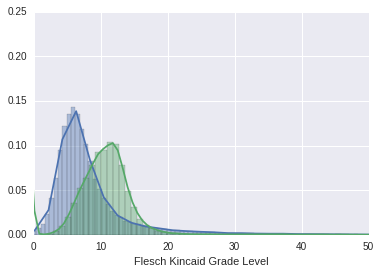

In [6]:
sns.distplot(df_crop['askergrd'],400)
sns.distplot(df_crop['doctorgrd'],100)
plt.xlim(0, 50)
plt.xlabel('Flesch Kincaid Grade Level')

KeyboardInterrupt: 

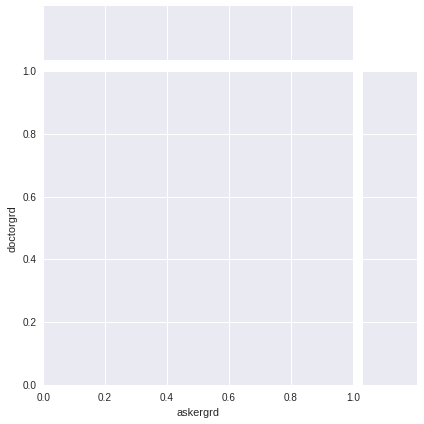

In [8]:
g = sns.jointplot(x='askergrd', y='doctorgrd', data=df_crop, kind="kde", color="m")
g.plot_joint(plt.scatter, c="k", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)

In [9]:
import cloudpickle
disease_lookup = cloudpickle.load(open("disease_lookup.pkl", "rb" ) )
disease_list = cloudpickle.load(open("disease_list.pkl", "rb" ) )
df_crop = cloudpickle.load(open("cleaned_forum_data.pkl", "rb" ) )


In [ ]:
from nltk import ngrams
from fuzzywuzzy import process
import string
from nltk.sentiment.util import mark_negation
import scipy.sparse as sps

all_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
ask_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
doc_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
dcn_lab= sps.lil_matrix((len(df_crop), len(disease_list)))

# fuzzy matching is way too slow (takes roughly 400000x longer)
# def get_toks(txt,ngram_length):
#     return [item for sublist in \
#              [[" ".join(grams) for grams in ngrams(txt.split(), n)] \
#              for n in range(ngram_length)] \
#              for item in sublist]

# def get_dislist(diseases,text_tok):
#     toreturn=[]
#     for k in diseases:
#         match =process.extractOne(k, text_tok)
#         if(match and match[1]>90 and 'NEG' not in match[0]):
#             toreturn.append(match[0])
#     return toreturn

# this is the easy way to search, it will miss a lot, but it will work for now
def get_dislist_simple(diseases,text):
    return [k for k in diseases if k in text]

# loop over all posts to perform the text analysis for labeling
for i,post in enumerate(df_crop['post'].values):
    if(i%1000==0):
        print i
    ask = df_crop.loc[df_crop['post']==post,'askertxt'].values[0].lower()
    doc = df_crop.loc[df_crop['post']==post,'doctortxt'].values[0].lower()
    oth = df_crop.loc[df_crop['post']==post,'othertxt'].values[0].lower()
    
    asktxt = ask.translate(None, string.punctuation)
    doctxt = doc.translate(None, string.punctuation)
    dcntxt = mark_negation(doc).translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    alltxt = (ask+' '+doc+' '+oth).translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    alldiags = get_dislist_simple(disease_lookup.keys(),alltxt)
    askdiags = get_dislist_simple(alldiags,asktxt)
    docdiags = get_dislist_simple(alldiags,doctxt)
    dcndiags = get_dislist_simple(docdiags,dcntxt)
    
    #better way to solve the problem, but will take roughly a year to finish (aaaahh)
#     ask_tok=get_toks(asktxt,3)
#     doc_tok=get_toks(doctxt,3)
#     dcn_tok=get_toks(dcntxt,3)
#     all_tok=get_toks(alltxt,3)
    
#     alldiags=get_dislist(disease_lookup.keys(),all_tok)
#     askdiags=get_dislist(alldiags,ask_tok)
#     docdiags=get_dislist(alldiags,doc_tok)
#     dcndiags=get_dislist(docdiags,dcn_tok)
    
    all_lab[i,list(set([disease_lookup[x] for x in alldiags]))]=1
    ask_lab[i,list(set([disease_lookup[x] for x in askdiags]))]=1
    doc_lab[i,list(set([disease_lookup[x] for x in docdiags]))]=1
    dcn_lab[i,list(set([disease_lookup[x] for x in dcndiags]))]=1

/home/will/anaconda/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/home/will/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000

In [ ]:
import cloudpickle
with open("alltext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(all_lab.asformat('csr'), handle)
with open("doctortext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(doc_lab.asformat('csr'), handle)
with open("doctornegtext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(dcn_lab.asformat('csr'), handle)
with open("askertext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(ask_lab.asformat('csr'), handle)